In [57]:
# 1. Introduction                 => Done
# 2. Groups                       => Done           
# 2.1 Apply TCR on RNA clusters   => Pending for AIR motifs function from earlier chapter
# 2.2 Apply RNA on TCR clusters   => TODO for TCR clonotype definition
# 3. Multimodal integration       => Done
# 3.1. TCR                        => Done
# 3.1.1 TESSA                     => Done
# 3.1.2 CONGA                     => Needs refactoring
# 3.1.3 mvTCR                     => Done
# 3.2. BCR                        => Done
# 3.2.1. new TESSA                => 
# 4. Take Home messages           => Done
# 5. Quiz                         => Done

# Introduction

With the development of novel single cell technology, IR sequencing is combined often with other Omic-layers, especially with transcriptomics. For B- and T-cells this enables the analysis of various characteristics on a single cell level: while the transcriptome provides insights into the current state of the cell, the IR is indicative for the cell's specificity and thereby explains the cell's fate upon infection or vaccination. 

# Data Preparation

First, we will combine the GEX with AIR data. Note, that we can do this also at earlier stages of single cell analysis: e.g. we can fuse both modalities already before preprocessing to filter GEX dublets. When fusing GEX and AIR data, a left join is often performed. I.e., only cells with GEX are kepted for analysis. Therefore, the order of fusing and filtering is not of great importance. However, it can be convinient to visualize the AIR information in an GEX UMAP in early stages. E.g. missing AIR information in clusters can help during cell type assignment.

In [24]:
import warnings

warnings.filterwarnings(
    "ignore",
    ".*IProgress not found*",
)
warnings.simplefilter(action="ignore", category=FutureWarning)

import scanpy as sc
import scirpy as ir
import pandas as pd
import numpy as np
import seaborn as sb

In [25]:
path_data = "./data"
path_gex_tcr = f"{path_data}/TCR_00_GEX.h5ad"
path_gex_bcr = f"{path_data}/BCR_00_GEX.h5ad"
path_tcr = f"{path_data}/TCR_01_preprocessed.h5ad"
path_bcr = f"{path_data}/BCR_01_preprocessed.h5ad"

path_tmp = f"{path_data}/tmp"
path_res = f"{path_data}/res"

First we will load the Gene expression data processed by the authors. You can download the full dataset from https://www.ebi.ac.uk/arrayexpress/files/E-MTAB-10026/E-MTAB-10026.processed.4.zip . Since we are working only with the B- and T-cells of selected donors, we provide a downsampled dataset for you:

! wget -O $path_bcr_input -nc # todo file link https://figshare.com/ndownloader/files/35574338

! wget -O $path_bcr_input -nc # todo file link https://figshare.com/ndownloader/files/35574338

Let's load the GEX and the previously annotated TCR data. Both AnnData objects can then easily be merged via scirpy into a shared AnnData object, which will store IR information in adata.obs and GEX in adata.X.

In [26]:
adata_tc = sc.read(path_gex_tcr)
adata_tcr = sc.read(path_tcr)

ir.pp.merge_with_ir(adata_tc, adata_tcr)

Let's calculate leiden clustering on the T cell transcritpome.

In [27]:
sc.pp.neighbors(adata_tc)
sc.tl.leiden(adata_tc)

To get an overview, we will plot the data with cluster assigment as a UMAP visualisation.

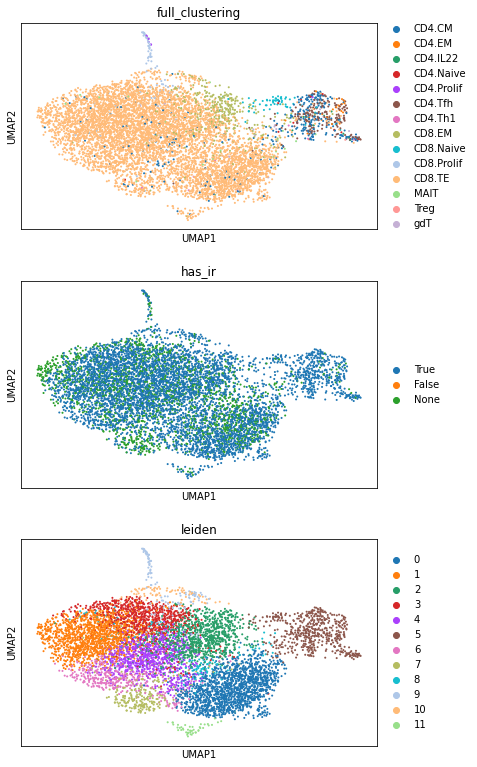

In [28]:
sc.tl.umap(adata_tc)
sc.pl.umap(adata_tc, color=["full_clustering", "has_ir", "leiden"], ncols=1)

Here, we can see, that the majority of cells belong to the CD8+ effector T cells. Also most of the cells express an TCR.

Similar, we merge with the BCR and GEX data for B cells.

In [29]:
adata_bc = sc.read(path_gex_bcr)
adata_bcr = sc.read(path_bcr)

ir.pp.merge_with_ir(adata_bc, adata_bcr)

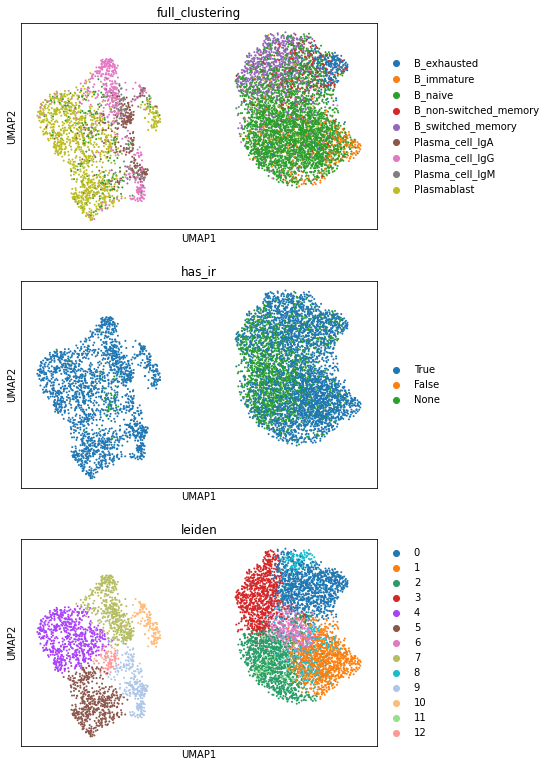

In [30]:
sc.pp.neighbors(adata_bc)
sc.tl.leiden(adata_bc)
sc.tl.umap(adata_bc)
sc.pl.umap(adata_bc, color=["full_clustering", "has_ir", "leiden"], ncols=1)

In this visualisation, we see a clear separation between Plasmablasts and B cells.

# Uni-modal Analysis with Cross-modal conditions

While studies often provide paired measurements for both modalities, these are often analyzed individually utilizing only limited shared information. Often one modality (VDJ or transcriptome) is used to provide conditions, on which the other modality is then analyzed. E.g. we can observe how cells from the same clonal lineage adapt to pertubation by DEG analysis of these cells in different points in time. 

Previously, we covered these unimodal analysis in other sections of this book. Here, we will focus, on how we can apply these techniques across VDJ and other modalities, rather than explaining the underlying approaches. To find a more detailed explanation please refer to the corresponding chapters.

## AIR analysis on RNA clusters

We have shown sequence and diversity analysis of AIRs in chapter (LINK UNIMODAL SEQUENCE ANALYSIS). When paired VDJ- and transcriptome data is available, we can perform similar analysis on cell clusters defined in the RNA-space. How these RNA-clusters are defined, is depending on the study design. Selected ways to define RNA clusters for AIR analysis:

- **Leiden Clusters**: Arguably the easiest way to define subsets of cells within count data, is via clustering algorithms. Usually, leiden clustering is performed and highly expressed genes of the clusters are used to determine the cells' state. We can now conduct the TCR analysis on clusters of interest (e.g. an activated cluster that is likely disease-specific). 
- **Marker Genes**: We can select AIR cells based on specific marker genes, that are indicative for specific cell states. Depending on your research questions, you should select your marker genes accordingly (e.g. markers for proliferation, activation, suppression).
- **Cell Types**: Several subcelltypes exist for B- and T-Cells for various degrees of hierachy. After these celltypes are annotated via transcriptome or other modalities, we can investigate how the repertoire composition differs among this label. This analysis can either be performed within sample (how does the repertoire differ between celltypes) or within a celltype across samples (e.g. how does the repertoire of CD8 effector T-cells change between disease and healthy patients).

In [13]:
# examples will be added once the clonotype + sequence analysis chapter are done to be consistent in tools and approaches.

In [ ]:
# example gene usage leiden clusters bcells

In [ ]:
# example motifs of IFNG T cells

In [ ]:
# example diversity cell types bcells

**Leiden Clusters**: Above we clustered the gene expression data via the leiden algorithm. We can now use the resulting groups to performane any kind of sequence analysis, e.g. spectratpying. For that, we simply replace the entry which defines the group parameter (here: color) with the column name of the leiden clustering ("leiden").

C:\Users\felix.drost\Anaconda3\envs\best_practice\lib\site-packages\scirpy\pl\base.py:262: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(order)


<AxesSubplot:title={'center':'Spectratype of IR_VJ_1_junction_aa by leiden'}, xlabel='IR_VJ_1_junction_aa length'>

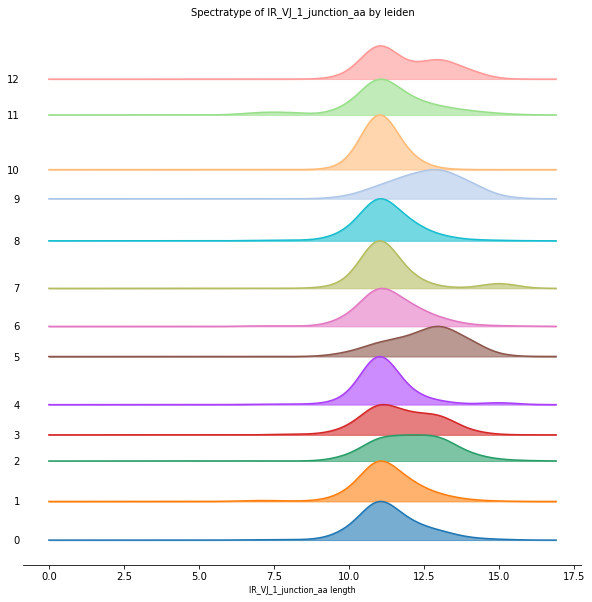

In [31]:
ir.pl.spectratype(
    adata_bc,
    color="leiden",
    viztype="curve",
    curve_layout="shifted",
    fig_kws={"figsize": [10, 10]},
    kde_kws={"kde_norm": False},
)

The BCR length of most leiden clusters follows a similar distribution. However, it is clear to see, that cluster 9 and 5 mainly contain BCRs with longer sequence length. These cells stem from a subcluster of plasmablasts and plasma cells. A diverging length profile can be caused by an immune reaction. It might therefore be useful to further investigate these clusters.

**Marker Genes**: Next, we can define our groups based on individual genes. As an example, we here pick Interferon Gamma as a marker for  pro-inflammatory immune response. This will provide us with a selection of cells which are currently innitating an immune response. 

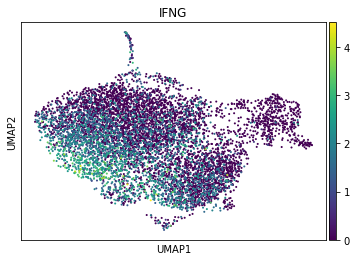

In [45]:
sc.pl.umap(adata_tc, color='IFNG')

When visualizing it, we observe, that it is present in a subset of CD8 effector T cells. Next, we will select cells with high IFNG score (abitrary threshold: 2.5) and annotate this selection in the adata object. To use it as category, we will store it as string. We can visualize the selected cells in the UMAP.

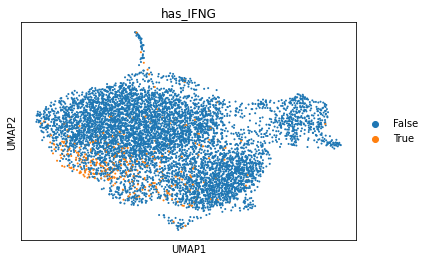

In [54]:
adata_tc.obs['has_IFNG'] = adata_tc[:, 'IFNG'].X.todense() > 2.5
adata_tc.obs['has_IFNG'] = adata_tc.obs['has_IFNG'].astype(str)
sc.pl.umap(adata_tc, color='has_IFNG')

Based on this annotation, we can now observe, whether the TCR motifs differs from the motif of the remaining cells.

In [55]:
# TODO waiting for motif function

**Cell Type**: Here, we apply the diversity between different celltypes annotated on the transcriptomic level (stored in "full_clustering"). We see, that proliferating and effector CD8 T cells have the lowest diversity. Since these celltypes contain larger clones, this was to be expected. Such an analysis could be used as a sanity check for the celltype assignment or to compare the diversity of celltypes over multiple studies.

100%|███████████████████████████████████████████████████████████████████████████████| 980/980 [00:03<00:00, 297.33it/s]


<AxesSubplot:title={'center':'Alpha diversity of clone_id by full_clustering'}, ylabel='Normalized Shannon Entropy'>

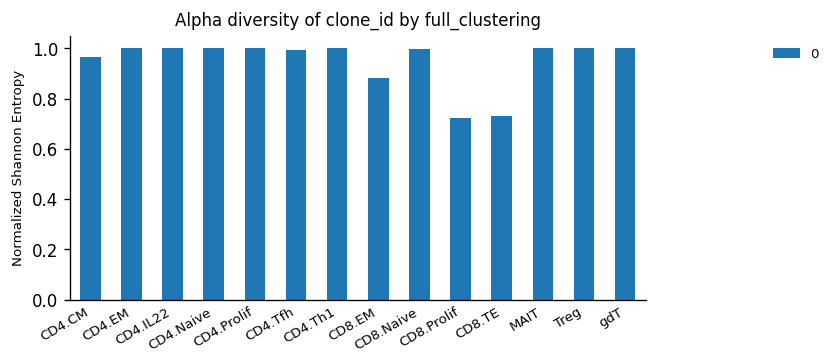

In [56]:
# TODO: remove clonotype definition once this is handled by clonotype chapter 
ir.tl.chain_pairing(adata_tc)
ir.pp.ir_dist(adata_tc, metric='identity', sequence='aa')
ir.tl.define_clonotype_clusters(adata_tc, metric='identity', receptor_arms='all', dual_ir='any', sequence='aa', 
                                key_added='clone_id')

ir.pl.alpha_diversity(adata_tc, groupby="full_clustering", target_col="clone_id", figsize=[8, 4])

## GEX analysis on AIR clusters
Similarly, we can perform the standard analysis of transcriptome (LINK UNIMODAL GEX ANALYSIS), but on groups derived in the AIR space. E.g.:

- **Clonotype**: AIR clonotypes can be used as clusters, if sufficient clonal expansion is present. This is especially intruiging, since the clonotype serves as a proxy for the cells specificity. Cells recognizing the same antigen can therefore be tracked over conditions such as time, treatment, or stimulation, to observe their change in 
- **Clonotype Network**: To increase the amount of cells to track, we can use networks of clonotypes with similar AIR sequence instead of clonotypes. While these cells are not ancestrally related, they are likely to share the same specificity.
- **Disease Specificity**: We previously queried databases, to detect epitope specific AIRs. We can now use this annotation, to investigate, how B- or T-cells reactive to selected diseases differ from other cells. Here, we must be cautious, since the dataset query provides us only with positive annotation: by same or similar AIR, we identify cells specific to a certain epitope. However, a missing pair of AIR and epitope in a database is not idicative, that this binding is not possible.

As for the previous subsection, the selcted condition and analysis are highly depended on your research question. In the following, we will again focus on how to use these conditions than on how to choose them.

In [14]:
# example will follow once clonotype definition is fixed

In [15]:
# Clonotype deg

In [16]:
# Clonotype network deg => comparison to above

In [17]:
# Disease specific cells => Covid B cells against rest

# Multimodal Integration
In the previous section we have shown, how modality specific analysis is performed on clusters derived from other modalities. However, this underutilizes the additional information provided by paired data, since AIRs and gene expression are interlinked: adaptive immune cells recognizing the same epitopes, will undergo a similar development upon activation. As for other omics-combination, there has been an interest lately in integrating AIR and GEX for deriving clusters or a shared representation. These models are still novel and are not part of most established analysis pipelines. We assume that these or similar approaches will be increasingly used in the future and therefore want to showcase these integration models. However, you should be careful when applying these models, since they are still experimental and not independently evaluated for their strengths and weaknesses.

## TCR
Only recently, three methods were developed to jointly utilize TCR sequences and transcriptome each aiming at different aspects of analysis: 
- **TESSA**: applies a Bayesian model on a TCR and GEX embedding for clustering T cells of similar transcriptome and sequences.
- **Conga**: clusters T cell clones through a graph-theoretic approach by distances of GEX and TCR
- **mvTCR**: uses Deep Variational Autoencoders to derive a shared embedding of GEX and TCR.

All multimodal approaches, require paired GEX and AIR data. We will therefore start by filtering all cells without CDR3β. 

In [7]:
adata_tc = adata_tc[~adata_tc.obs['IR_VDJ_1_junction_aa'].isna()].copy()

### TESSA
Zhang et al developed TCR functional landscape estimation supervised with scRNA-seq analysis (TESSA) {cite}'zhang2021mapping', which aims at embedding and clustering T cell clones based on their TCR sequence and transcriptome via Bayesian modelling. The CDR3β sequence is first compressed to a 30-dimensional numeric representation using a pretrained Autoencoder. Following, the dimensions are upweighted to correlate the TCR representation with the gene expression of similar TCR-groups, thereby assigning importance of TCR position? for explaining the cells gene expression. In an interative process, weights and groups are updated until convergence to reach a maximal allignment between both modalities.

TESSA produced clusters of high purity when embedding Tcells with known epitope specificity from {cite}'10x2019new', surpasing the uni-modal model GLIPH {cite}'glanville2017identifying', which is commonly used for clustering TCR sequences. Further, cluster centrally was indicative for higher avidity clones shown by clonal expansion and high ADT counts. Using TESSA on data from {cite}'yost2019clonal', the author detected novel clusters of responder T cell in patients undergoing PD-1 blockade. 

The code and instructions for installation can be found [here](https://github.com/jcao89757/TESSA).

#### Data Preprocessing
TESSA requires several TCR and GEX files in specific format.

First, we save a ".csv"-File with the the following columns:
- **contig_id**: cell barcodes as index column
- **cdr3**: CDR3β amino acid sequence trimmed of starting C and ending F

In [8]:
df_tcr = adata_tc.obs
df_tcr.index.name = "contig_id"

# trimm cdr3 sequence
df_tcr["cdr3"] = [
    seq[1:-1] for seq in df_tcr["IR_VDJ_1_junction_aa"]
]

# select only columns needed
df_tcr = df_tcr[["cdr3"]] 

df_tcr.to_csv(f"{path_tmp}/TESSA_tcrs.csv")
df_tcr.head(5)

,cdr3
contig_id,
S11_AAACCTGAGATTACCC-1,ASSLDARDRGRVTEAF
S11_AAACCTGGTAATTGGA-1,ASSPGTGTYGYT
S11_AAACCTGGTAGCACGA-1,ASSIPGAVHEQY
S11_AAACCTGGTCTCAACA-1,ASSLDARDRGRVTEAF
S11_AAACCTGTCGCCGTGA-1,ASSPQTGVARYGYT


We will filter the 10% most variable genes, as done in the TESSA publication.

In [9]:
n_genes = adata_tc.shape[1] // 10
sc.pp.highly_variable_genes(adata_tc, n_top_genes=n_genes)
adata_tessa = adata_tc[:, adata_tc.var["highly_variable"]].copy()

We now store the GEX matrix to a ".csv"-File. TESSA requires the transposed matrix of the adata object. I.e. the rows represent the different genes and the columns indicate a specific cell. For this, we will store the count data in a DataFrame with the right index and column names. Following, we transpose the DataFrame.

In [10]:
count_mat = adata_tessa.X.A
df_counts = pd.DataFrame(count_mat)

df_counts.index = adata_tessa.obs.index
df_counts.index.name = ""
df_counts.columns = adata_tessa.var.index

df_counts = df_counts.transpose()

df_counts.to_csv(f"{path_tmp}/TESSA_gex.csv")
df_counts.head()

S11_AAACCTGAGATTACCC-1  S11_AAACCTGGTAATTGGA-1  \
KLHL17                0.000000                     0.0   
HES4                  0.000000                     0.0   
ISG15                 1.845827                     0.0   
AGRN                  0.000000                     0.0   
TTLL10                0.000000                     0.0   

        S11_AAACCTGGTAGCACGA-1  S11_AAACCTGGTCTCAACA-1  \
KLHL17                 0.00000                0.000000   
HES4                   0.00000                0.000000   
ISG15                  1.54457                2.441434   
AGRN                   0.00000                0.000000   
TTLL10                 0.00000                0.000000   

        S11_AAACCTGTCGCCGTGA-1  S11_AAACCTGTCTTATCTG-1  \
KLHL17                0.000000                  0.0000   
HES4                  0.000000                  0.0000   
ISG15                 2.430966                  0.9284   
AGRN                  0.000000                  0.0000   
TTLL10                0.000000                  0.0000   

        S11_AAACGGGCAAGAAAGG-1  S11_AAACGGGGTAGCGATG-1  \
KLHL17                     0.0                     0.0   
HES4                       0.0                     0.0   
ISG15                      0.0                     0.0   
AGRN                       0.0                     0.0   
TTLL10                     0.0                     0.0   

        S11_AAACGGGGTCGGCACT-1  S11_AAACGGGGTTACGGAG-1  ...  \
KLHL17                 0.00000                0.000000  ...   
HES4                   0.00000                0.000000  ...   
ISG15                  1.64661                1.565189  ...   
AGRN                   0.00000                0.000000  ...   
TTLL10                 0.00000                0.000000  ...   

        S12_TTTGGTTGTCAGAGGT-1  S12_TTTGGTTTCAAGAAGT-1  \
KLHL17                0.000000                     0.0   
HES4                  0.000000                     0.0   
ISG15                 1.210719                     0.0   
AGRN                  0.000000                     0.0   
TTLL10                0.000000                     0.0   

        S12_TTTGGTTTCTACTATC-1  S12_TTTGGTTTCTCGCTTG-1  \
KLHL17                0.000000                0.000000   
HES4                  0.000000                0.000000   
ISG15                 1.581859                1.511785   
AGRN                  0.000000                0.000000   
TTLL10                0.000000                0.000000   

        S12_TTTGTCACACGGTAGA-1  S12_TTTGTCAGTAGAAAGG-1  \
KLHL17                1.662003                0.000000   
HES4                  0.000000                0.000000   
ISG15                 0.000000                2.015501   
AGRN                  0.000000                0.000000   
TTLL10                0.000000                0.000000   

        S12_TTTGTCAGTCCAACTA-1  S12_TTTGTCAGTGAGTGAC-1  \
KLHL17                     0.0                0.000000   
HES4                       0.0                0.000000   
ISG15                      0.0                2.088418   
AGRN                       0.0                0.000000   
TTLL10                     0.0                0.000000   

        S12_TTTGTCATCCACTCCA-1  S12_TTTGTCATCGCATGAT-1  
KLHL17                0.000000                     0.0  
HES4                  0.000000                     0.0  
ISG15                 1.611682                     0.0  
AGRN                  0.000000                     0.0  
TTLL10                0.000000                     0.0  

[5 rows x 5281 columns]

#### Running the model
We need to provide different setting options, most of which specify input or output directories. We will summarize them in a dictionary first.

In [11]:
settings_full = {
    # Input files
    "tcr": f"{path_tmp}/TESSA_tcrs.csv",
    "exp": f"{path_tmp}/TESSA_gex.csv",
    # TESSA models
    "model": f"TESSA/BriseisEncoder/TrainedEncoder.h5",
    "embeding_vectors": f"TESSA/BriseisEncoder/Atchley_factors.csv",
    # Output files
    "output_TCR": f"{path_res}/TESSA_tcr_embedding.csv",
    "output_log": f"{path_res}/TESSA_log.log",
    "output_tessa": f"{path_res}",
    "within_sample_networks": "FALSE",
}

In the next step, we will create the command for running TESSA by adding setting key and setting option.

In [12]:
cmd_tessa = "source ~/.bashrc &&"
cmd_tessa += "conda activate TESSA && "

cmd_tessa += "python TESSA/Tessa_main.py"
for key, value in settings_full.items():
    cmd_tessa += f" -{key} {value}"
cmd_tessa

'source ~/.bashrc &&conda activate TESSA && python TESSA/Tessa_main.py -tcr ./data/tmp/TESSA_tcrs.csv -exp ./data/tmp/TESSA_gex.csv -model TESSA/BriseisEncoder/TrainedEncoder.h5 -embeding_vectors TESSA/BriseisEncoder/Atchley_factors.csv -output_TCR ./data/res/TESSA_tcr_embedding.csv -output_log ./data/res/TESSA_log.log -output_tessa ./data/res -within_sample_networks FALSE'

Finally, we run the model on the specified settings by calling the command. Depending on your compute ressources this might take several minutes.

In [34]:
!$cmd_tessa

Using TensorFlow backend.
/home/icb/felix.drost/miniconda/envs/TESSA/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/icb/felix.drost/miniconda/envs/TESSA/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/icb/felix.drost/miniconda/envs/TESSA/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

  Recent b acceptance rate: 0 

Iteration round: 60 
  # clusters: 122 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 61 
  # clusters: 123 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

Iteration round: 62 
  # clusters: 122 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 63 
  # clusters: 123 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

Iteration round: 64 
  # clusters: 124 
  Clustering rate: 0.997 
  Recent b acceptance rate: 0 

Iteration round: 65 
  # clusters: 123 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

Iteration round: 66 
  # clusters: 122 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 67 
  # clusters: 122 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 68 
  # clusters: 123 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

Iteration round: 69 
  # clusters: 123 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

Iter

  Recent b acceptance rate: 0 

Iteration round: 146 
  # clusters: 121 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 147 
  # clusters: 122 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

Iteration round: 148 
  # clusters: 121 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 149 
  # clusters: 122 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

Iteration round: 150 
  # clusters: 121 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 151 
  # clusters: 122 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

Iteration round: 152 
  # clusters: 121 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 153 
  # clusters: 121 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 154 
  # clusters: 123 
  Clustering rate: 0.997 
  Recent b acceptance rate: 0 

Iteration round: 155 
  # clusters: 122 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

  Recent b acceptance rate: 0 

Iteration round: 231 
  # clusters: 124 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 232 
  # clusters: 125 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

Iteration round: 233 
  # clusters: 124 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 234 
  # clusters: 124 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 235 
  # clusters: 124 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 236 
  # clusters: 124 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 237 
  # clusters: 124 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 238 
  # clusters: 126 
  Clustering rate: 0.997 
  Recent b acceptance rate: 0 

Iteration round: 239 
  # clusters: 125 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

Iteration round: 240 
  # clusters: 125 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iterat

  Recent b acceptance rate: 0 

Iteration round: 317 
  # clusters: 127 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 318 
  # clusters: 127 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 319 
  # clusters: 127 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 320 
  # clusters: 128 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

Iteration round: 321 
  # clusters: 127 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 322 
  # clusters: 127 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 323 
  # clusters: 127 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 324 
  # clusters: 127 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 325 
  # clusters: 127 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 326 
  # clusters: 127 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration roun

  Recent b acceptance rate: 0 

Iteration round: 403 
  # clusters: 127 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 404 
  # clusters: 127 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 405 
  # clusters: 127 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 406 
  # clusters: 127 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 407 
  # clusters: 127 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 408 
  # clusters: 127 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 409 
  # clusters: 127 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 410 
  # clusters: 128 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

Iteration round: 411 
  # clusters: 127 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 412 
  # clusters: 127 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration roun

  Recent b acceptance rate: 0 

Iteration round: 489 
  # clusters: 127 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 490 
  # clusters: 127 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 491 
  # clusters: 127 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 492 
  # clusters: 127 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 493 
  # clusters: 127 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 494 
  # clusters: 127 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 495 
  # clusters: 127 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 496 
  # clusters: 127 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 497 
  # clusters: 127 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 498 
  # clusters: 127 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 4

  Recent b acceptance rate: 0 

Iteration round: 575 
  # clusters: 127 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 576 
  # clusters: 127 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 577 
  # clusters: 128 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

Iteration round: 578 
  # clusters: 127 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 579 
  # clusters: 127 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 580 
  # clusters: 128 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

Iteration round: 581 
  # clusters: 127 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 582 
  # clusters: 127 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 583 
  # clusters: 128 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

Iteration round: 584 
  # clusters: 127 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iterat

  Recent b acceptance rate: 0 

Iteration round: 661 
  # clusters: 128 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 662 
  # clusters: 128 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 663 
  # clusters: 128 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 664 
  # clusters: 129 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

Iteration round: 665 
  # clusters: 128 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 666 
  # clusters: 128 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 667 
  # clusters: 128 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 668 
  # clusters: 128 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 669 
  # clusters: 128 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 670 
  # clusters: 128 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration roun

  Recent b acceptance rate: 0 

Iteration round: 747 
  # clusters: 128 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 748 
  # clusters: 128 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 749 
  # clusters: 128 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 750 
  # clusters: 128 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 751 
  # clusters: 129 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

Iteration round: 752 
  # clusters: 128 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 753 
  # clusters: 129 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

Iteration round: 754 
  # clusters: 128 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 755 
  # clusters: 128 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 756 
  # clusters: 129 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

Iterat

  Recent b acceptance rate: 0 

Iteration round: 833 
  # clusters: 128 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 834 
  # clusters: 129 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

Iteration round: 835 
  # clusters: 129 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

Iteration round: 836 
  # clusters: 128 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 837 
  # clusters: 128 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 838 
  # clusters: 128 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 839 
  # clusters: 129 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

Iteration round: 840 
  # clusters: 128 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 841 
  # clusters: 128 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 842 
  # clusters: 128 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iterat

  Recent b acceptance rate: 0 

Iteration round: 919 
  # clusters: 129 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 920 
  # clusters: 129 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 921 
  # clusters: 129 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 922 
  # clusters: 129 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 923 
  # clusters: 129 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 924 
  # clusters: 129 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 925 
  # clusters: 129 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 926 
  # clusters: 129 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 927 
  # clusters: 130 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

Iteration round: 928 
  # clusters: 131 
  Clustering rate: 0.997 
  Recent b acceptance rate: 0 

Iteration 

#### Output
We now recieve three output files: hat we can further use for downstream tasks:
- **TESSA_tcr_embedding.csv**: Embedding of TCRs (without GEX information)
- **result_meta.csv**: cluster assignment by cell
- **tessa_final.RData**: Containing inferred model parameters (e.g. weightening vector b)

Here, we will use the first two files as embedding and clustering. We will store them in Scanpy format for easier handling. To avoid the clustering to be dominated by highly expanded clones, we reduce the cell-level data to a clone-level by removing duplicate TCRs.

In [14]:
tessa_embedding = pd.read_csv(f"{path_res}/TESSA_tcr_embedding.csv", index_col=0)
tessa_embedding = tessa_embedding.drop_duplicates()
tessa_obs = adata_tc[adata_tc.obs.index.isin(tessa_embedding.index)].obs
tessa_embedding = sc.AnnData(X=tessa_embedding.values, obs=tessa_obs)

Next, we will add the TESSA cluster assignment to the AnnData object. Since TESSA internally changes the barcode slightly, we will need to adjust for that. Additionally, we drop the duplicate TCRs within a cluster.

In [15]:
clustering = pd.read_csv(f"{path_res}/result_meta.csv", index_col=0)
clustering.index = clustering.index.str.replace('.', '-')
clustering = clustering[clustering.index.isin(tessa_embedding.obs.index)]
tessa_embedding.obs["TESSA_cluster"] = clustering["cluster_number"].values

print(f"Unique clones: {tessa_embedding.obs['cdr3'].nunique()}")
print(f"Unique clusters: {tessa_embedding.obs['TESSA_cluster'].nunique()}")

Unique clones: 751
Unique clusters: 132


You can see, that 751 clones were grouped to 144 clusters, which have similar TCR sequences and are likely to be functionally related. For TSNE visualisation {cite}'', we will highlight the ten largest clusters in the TCR embedding space.

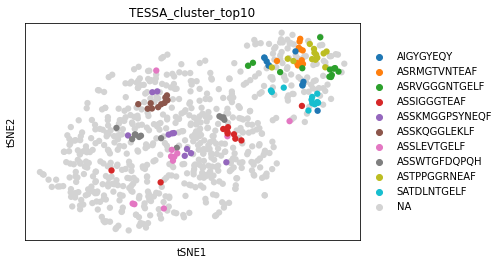

In [16]:
sc.pp.neighbors(tessa_embedding)
sc.tl.tsne(tessa_embedding)

top_10_clusters = tessa_embedding.obs["TESSA_cluster"].value_counts().head(10).index
tessa_embedding.obs["TESSA_cluster_top10"] = tessa_embedding.obs["TESSA_cluster"].apply(
    lambda x: x if x in top_10_clusters else np.nan
)

sc.pl.tsne(tessa_embedding, color="TESSA_cluster_top10")

For plotting the cluster assignemnt in the GEX space, we add the assignment to the original adata object. When plotting, we can see that TESSA clusters also share similar phenotypes at GEX level.

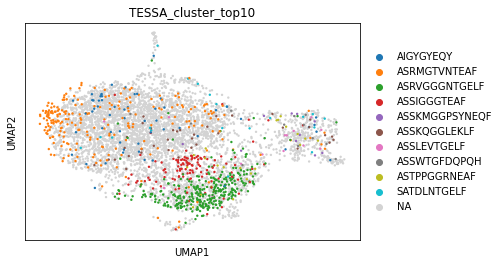

In [17]:
mapping_dict = dict(tessa_embedding.obs[['IR_VDJ_1_junction_aa', 'TESSA_cluster_top10']].values)
adata_tc.obs["TESSA_cluster_top10"] = adata_tc.obs['IR_VDJ_1_junction_aa'].map(mapping_dict)
sc.pl.umap(adata_tc, color="TESSA_cluster_top10")

We can see in both visualisations, that the clusters are related on a TCR and GEX level. However, the full clustering can not directly observed in a single modality. Due to similar TCR and GEX profile, these cells might be specific to the same epitopes. Examplatory, we could use this annotation for DEG analysis between cell networks as described above.

# CoNGA
clonotype neighbor graph analysis (CoNGA) uses similarity graphs at a clonotype level on GEX and TCR, for which the well known distance metric TCRDist [] is used. Based on the graph neighborhood, clusters are formed by shared GEX and TCR assignments. These so called "CoNGA clusters" thereby share similar receptor sequences as well as similar gene expression. CoNGA clusters contained clonotypes with highly alike TCRs based on e.g. length and physio-chemical properties and were shown to capture specificity well on []. Among other things, CoNGA was used to identified clusters of mhc-indepent HOBIT/HELIOS-type T-cells in data from []. The following explanation is a compressed version of the authors explanation at https://github.com/phbradley/conga/blob/master/colab_conga_pipeline.ipynb

## Installation

In [158]:
!pip install cairosvg

  Created wheel for cairocffi: filename=cairocffi-1.3.0-py3-none-any.whl size=89683 sha256=4fa8f0076447dfe0b40422207475bd1b2c3b162f0914c75ea21a7c4cd9dfffd7
  Stored in directory: c:\users\felix.drost\appdata\local\pip\cache\wheels\4e\ca\e1\5c8a9692a27f639a07c949044bec943f26c81cd53d3805319f
Successfully built cairocffi


In [159]:
!git clone https://github.com/phbradley/conga.git

Cloning into 'conga'...
Updating files:  93% (122/131)
Updating files:  94% (124/131)
Updating files:  95% (125/131)
Updating files:  96% (126/131)
Updating files:  97% (128/131)
Updating files:  98% (129/131)
Updating files:  99% (130/131)
Updating files: 100% (131/131)
Updating files: 100% (131/131), done.


In [9]:
! cd conga//tcrdist_cpp// && make
g++ -O3 -std=c++11 -Wall -I ./include/ -o ./bin/find_neighbors ./src/find_neighbors.cc

In file included from ./include/tclap/Arg.h:55,
                 from ./include/tclap/SwitchArg.h:30,
                 from ./include/tclap/CmdLine.h:27,
                 from ./src/misc.hh:12,
                 from ./src/tcrdist.hh:7,
                 from ./src/find_neighbors.cc:2:
./include/tclap/ArgTraits.h: In instantiation of 'struct TCLAP::ArgTraits<long long unsigned int>':
./include/tclap/ValueArg.h:403:51:   required from 'void TCLAP::ValueArg<T>::_extractValue(const string&) [with T = long long unsigned int; std::string = std::__cxx11::basic_string<char>]'
./include/tclap/ValueArg.h:363:5:   required from 'bool TCLAP::ValueArg<T>::processArg(int*, std::vector<std::__cxx11::basic_string<char> >&) [with T = long long unsigned int]'
./include/tclap/ValueArg.h:328:6:   required from here
./include/tclap/ArgTraits.h:80:39: error: 'long long unsigned int' is not a class, struct, or union type
   80 |     typedef typename T::ValueCategory ValueCategory;
      |                     

In [165]:
! cd conga// && pip install -e .

Obtaining file:///C:/Daten/Projects/BestPractice2.0/notebooks/multimodal_vdj/conga
  Running setup.py develop for conga


## Data Preperation

In [22]:
path_reduced_joint = f"{path_data}/joint_data_reduced.h5ad"
sc.write(adata=adata, filename=path_reduced_joint)

In [23]:
df_tcr = pd.read_csv(
    f"{path_data}/E-MTAB-10026.processed.2/TCR_merged-Updated.tsv",
    sep="\t",
    index_col=0,
)
df_tcr = df_tcr.loc[adata.obs.index]

path_reduced_tcr = f"{path_data}/tcr_reduced.h5ad"
df_tcr.to_csv(path_reduced_tcr)

C:\Users\felix.drost\Anaconda3\envs\best_practice\lib\site-packages\IPython\core\interactiveshell.py:3186: DtypeWarning: Columns (38,39,40) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
import conga

organism = "human"

path_clones = f"{path_tmp}/cogna_clones.tsv"
outfile_prefix = "conga"

In [29]:
conga.tcrdist.make_10x_clones_file.make_10x_clones_file(
    path_reduced_tcr, organism, path_clones
)
conga.preprocess.make_tcrdist_kernel_pcs_file_from_clones_file(path_clones, organism)

repeat?? 2 222 ('TRBV18*01', 'TRBJ1-4*01', 'CASSIGGQIYEKLFF', 'tgtgccagtagtattggagggcagatatatgaaaaactgtttttt') ('TRBV19*01', 'TRBJ1-4*01', 'CASSIGGQIYEKLFF', 'tgtgccagtagtattggagggcagatatatgaaaaactgtttttt')
repeat?? 2 88 ('TRAV18*01', 'TRAJ40*01', 'CALSPQTPGTYKYIF', 'tgtgctctgagtccccaaaccccaggaacctacaaatacatcttt') ('TRAV19*01', 'TRAJ40*01', 'CALSPQTPGTYKYIF', 'tgtgctctgagtccccaaaccccaggaacctacaaatacatcttt')
repeat?? 472 11 ('TRBV11-2*01', 'TRBJ2-1*01', 'CASSLDLLLRYNEQFF', 'tgtgccagcagcttagatctactactaagatacaatgagcagttcttc') ('TRBV7-2*01', 'TRBJ2-1*01', 'CASSLDLLLRYNEQFF', 'tgtgccagcagcttagatctactactaagatacaatgagcagttcttc')
ab_counts: [((1, 1), 2107), ((2, 2), 1834), ((2, 1), 112), ((3, 2), 103), ((2, 3), 99), ((3, 3), 64), ((4, 2), 14), ((1, 2), 9)]
old_unpaired_barcodes: 0 old_paired_barcodes: 4350 new_stringent_paired_barcodes: 2219
compute tcrdist distance matrix for 629 clonotypes
Using Python TCRdist calculator. Consider compiling C++ calculator for faster perfomance.
running Kerne

In [35]:
df_tcr

,Centre,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,...,Days_from_onset,time_after_LPS,Worst_Clinical_Status,Outcome,leiden,consensus,initial_clustering,study_id,AgeRange,Age
CellID,,,,,,,,,,,,,,,,,,,,,
S11_AAACCTGGTAATTGGA-1,Sanger,AAACCTGGTAATTGGA-1,True,AAACCTGGTAATTGGA-1_contig_2,True,677,TRA,TRAV12-1,None,TRAJ9,...,17,NaN,NaN,unknown,2,CD8,CD8,AP6,"(80, 89]",80
S11_AAACCTGGTAATTGGA-1,Sanger,AAACCTGGTAATTGGA-1,True,AAACCTGGTAATTGGA-1_contig_1,True,473,TRB,TRBV10-2,None,TRBJ1-2,...,17,NaN,NaN,unknown,2,CD8,CD8,AP6,"(80, 89]",80
S11_AAACCTGGTAGCACGA-1,Sanger,AAACCTGGTAGCACGA-1,True,AAACCTGGTAGCACGA-1_contig_1,True,657,TRB,TRBV19,None,TRBJ2-7,...,17,NaN,NaN,unknown,2,CD8,CD8,AP6,"(80, 89]",80
S11_AAACCTGGTAGCACGA-1,Sanger,AAACCTGGTAGCACGA-1,True,AAACCTGGTAGCACGA-1_contig_2,True,551,TRA,TRAV26-2,None,TRAJ53,...,17,NaN,NaN,unknown,2,CD8,CD8,AP6,"(80, 89]",80
S11_AAACCTGTCGCCGTGA-1,Sanger,AAACCTGTCGCCGTGA-1,True,AAACCTGTCGCCGTGA-1_contig_2,True,475,TRA,TRAV24,None,TRAJ49,...,17,NaN,NaN,unknown,26,CD8,CD8,AP6,"(80, 89]",80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S12_TTTGTCAGTGAGTGAC-1,Sanger,TTTGTCAGTGAGTGAC-1,True,TTTGTCAGTGAGTGAC-1_contig_1,True,521,TRB,TRBV6-5,None,TRBJ1-2,...,17,NaN,NaN,unknown,19,CD8,CD8,AP6,"(80, 89]",80
S12_TTTGTCATCCACTCCA-1,Sanger,TTTGTCATCCACTCCA-1,True,TTTGTCATCCACTCCA-1_contig_2,True,561,TRB,TRBV5-6,None,TRBJ2-7,...,17,NaN,NaN,unknown,26,CD8,CD8,AP6,"(80, 89]",80
S12_TTTGTCATCCACTCCA-1,Sanger,TTTGTCATCCACTCCA-1,True,TTTGTCATCCACTCCA-1_contig_1,True,634,TRA,TRAV8-6,None,TRAJ57,...,17,NaN,NaN,unknown,26,CD8,CD8,AP6,"(80, 89]",80


In [36]:
adata.obs

,sample_id,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,full_clustering,initial_clustering_x,Resample,Collection_Day_x,...,time_after_LPS_y,Worst_Clinical_Status_y,Outcome_y,initial_clustering_y,study_id,AgeRange,Age,receptor_type,receptor_subtype,chain_pairing
covid_index,,,,,,,,,,,,,,,,,,,,,
S11_AAACCTGGTAATTGGA-1,AP6,1763,1763,3950.0,12.0,0.303797,CD8.TE,CD8,Initial,D0,...,NaN,NaN,unknown,CD8,AP6,"(80, 89]",80.0,TCR,TRA+TRB,single pair
S11_AAACCTGGTAGCACGA-1,AP6,1400,1400,2713.0,11.0,0.405455,CD8.TE,CD8,Initial,D0,...,NaN,NaN,unknown,CD8,AP6,"(80, 89]",80.0,TCR,TRA+TRB,single pair
S11_AAACCTGTCGCCGTGA-1,AP6,1321,1321,2893.0,30.0,1.036986,CD8.TE,CD8,Initial,D0,...,NaN,NaN,unknown,CD8,AP6,"(80, 89]",80.0,TCR,TRA+TRB,single pair
S11_AAACCTGTCTTATCTG-1,AP6,2268,2268,6534.0,81.0,1.239669,CD4.CM,CD4,Initial,D0,...,NaN,NaN,unknown,CD4,AP6,"(80, 89]",80.0,TCR,TRA+TRB,single pair
S11_AAACGGGGTAGCGATG-1,AP6,1410,1410,4349.0,77.0,1.770522,CD8.Naive,CD8,Initial,D0,...,NaN,NaN,unknown,CD8,AP6,"(80, 89]",80.0,TCR,TRA+TRB,extra VJ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S12_TTTGTCACACGGTAGA-1,AP6,1186,1186,2342.0,13.0,0.555081,CD8.TE,CD8,Initial,D0,...,NaN,NaN,unknown,CD8,AP6,"(80, 89]",80.0,TCR,TRA+TRB,single pair
S12_TTTGTCAGTAGAAAGG-1,AP6,2680,2680,7687.0,71.0,0.923637,CD8.TE,CD8,Initial,D0,...,NaN,NaN,unknown,CD8,AP6,"(80, 89]",80.0,TCR,TRA+TRB,single pair
S12_TTTGTCAGTGAGTGAC-1,AP6,1335,1335,2828.0,24.0,0.848656,CD8.TE,CD8,Initial,D0,...,NaN,NaN,unknown,CD8,AP6,"(80, 89]",80.0,TCR,TRA+TRB,single pair


In [30]:
adata_cogna = conga.preprocess.read_dataset(path_reduced_joint, "h5ad", path_clones)
adata_conga.uns["organism"] = organism

reading: data/joint_data_reduced.h5ad of type h5ad


c:\daten\projects\bestpractice2.0\notebooks\multimodal_vdj\conga\conga\preprocess.py:226: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if adata.isview: # ran into trouble with AnnData views vs copies


total barcodes: 4350 (4350, 24929)
reading: tmp/cogna_clones.tsv
reading: tmp/cogna_clones_AB.dist_50_kpcs
Reducing to the 0 barcodes (out of 4350) with paired TCR sequence data


AttributeError: Can only use .str accessor with string values!

In [ ]:
adata_conga = conga.preprocess.reduce_to_single_cell_per_clone(adata_conga)

In [ ]:
adata_conga = conga.preprocess.cluster_and_tsne_and_umap(adata_conga)
# todo plot umap

In [ ]:
# these are the nbrhood sizes, as a fraction of the entire dataset:
nbr_fracs = [0.01, 0.1]

# we use this nbrhood size for computing the nndists
nbr_frac_for_nndists = 0.01

all_nbrs, nndists_gex, nndists_tcr = conga.preprocess.calc_nbrs(
    adata, nbr_fracs, also_calc_nndists=True, nbr_frac_for_nndists=nbr_frac_for_nndists
)

# stash these in obs array, they are used in a few places...
adata.obs["nndists_gex"] = nndists_gex
adata.obs["nndists_tcr"] = nndists_tcr

conga.preprocess.setup_tcr_cluster_names(adata)  # stores in adata.uns

In [ ]:
results = conga.correlations.run_graph_vs_graph(
    adata, all_nbrs, outfile_prefix=outfile_prefix
)

In [ ]:
conga_scores umap

In [ ]:
nbrs_gex, nbrs_tcr = all_nbrs[0.1]

min_cluster_size = 5

conga.plotting.make_graph_vs_graph_logos(
    adata,
    outfile_prefix,
    min_cluster_size,
    nbrs_gex,
    nbrs_tcr,
)

In [ ]:
conga.correlations.run_graph_vs_features(adata, all_nbrs, outfile_prefix=outfile_prefix)

In [ ]:
conga.plotting.make_graph_vs_features_plots(adata, all_nbrs, outfile_prefix)

### mvTCR
mvTCR by An et al is a multiview Variational Autoencoder that compresses TCR sequence and gene expression into a lower-dimensional representation {cite}'an2021jointly'. Two deep learning archtictures - Transformer and Multi-layer perceptron - extract information from both TCR and GEX respectively, before they are fused to derive the joint space. Following, the trained models can be used to embedd similar data. 

The authors showed, that multi-modal models can better capture antigen specificity, than uni-modal embeddings on the data from {cite}'10x2019new' for prediction and clustering. Additionally, they showed that cell type and cell functionality are preserved in the embedding space on a SARS-CoV-2 dataset from {cite}'fischer2021single'. Code and further explanations are available [here](https://github.com/SchubertLab/mvTCR).

mvTCR relies on the Scanpy format. For training the model, we need to prepare our adata object. For that, the several functions are provided.

In [36]:
import sys

sys.path.append("mvTCR")
sys.path.append(".")

import tcr_embedding.utils_training as utils
from tcr_embedding.models.model_selection import run_model_selection
from tcr_embedding.utils_preprocessing import group_shuffle_split, encode_tcr

The adata object requires a clonotype assignement (see notebook X). Since mvTCR uses both chains of the primary receptor, we will use this information for defining the clonotype as well. # todo => use the one provided

In [40]:
adata_mvtcr = adata_tc[~adata_tc.obs['IR_VJ_1_junction_aa'].isna()].copy()

In [41]:
ir.tl.define_clonotypes(
    adata_mvtcr, key_added="clonotype", receptor_arms="all", dual_ir="primary_only"
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 728/728 [00:00<00:00, 881.74it/s]


The model requires a numeric encoding of the CDR3α and CDR3β chain. For that, we need to provide the columns containing the amino acid sequences. Additional, the pad attribute indicates the maximal length of the sequence. If we do not want to embedd aditional data afterwards, we can set it to the maximal sequence length.

In [42]:
pad = max(
    adata_mvtcr.obs["IR_VJ_1_junction_aa"].str.len().max(),
    adata_mvtcr.obs["IR_VDJ_1_junction_aa"].str.len().max(),
)
encode_tcr(
    adata_mvtcr,
    column_cdr3a="IR_VJ_1_junction_aa",
    column_cdr3b="IR_VDJ_1_junction_aa",
    pad=pad,
)

The data needs to be divided into a training and validation data. This is done by setting the values 'train' or 'val' for each cell in adata.obs['set']. By choosing the 'clonotype' and 0.2, the dataset used to evaluate the models performance will contain approximately 20% of unique clonotypes to the training set. This setting can generally be used for data analysis.

In [44]:
train, val = group_shuffle_split(adata_mvtcr, group_col="clonotype", val_split=0.2)
adata_mvtcr.obs["set"] = "train"
adata_mvtcr.obs.loc[val.obs.index, "set"] = "val"

We need to provide various information, that are used during training:

In [50]:
params_experiment = {
    "study_name": "test_haniffa",  # Name that identifies the study
    "model_name": "moe",  # Type of mixture model used during training, authors suggest using Mixture of Export (moe)
    "balanced_sampling": "clonotype",  # Column containing the id for clonotypes
    "comet_workspace": None,  # Can be used to log experiments via comet-ml
    "save_path": path_res,  # Output path, were the selected models are stored
}

mvTCR runs a hyperparameter optimization to choose the best model architecture. For general analysis, the optimization mode 'pseudo_metric' is most suited. Here, the best model is determined by the capability of preserving multiple characteristics of the dataset. In the following, we choose identical TCR sequence ('clonotype') and cell type ('functional.cluster') both equally weighted (1 and 1). If after training the model, the latent space is dominated by one modality, we can rerun the model with different weightings.

In [46]:
params_optimization = {
    "name": "pseudo_metric",
    "prediction_labels": {"clonotype": 1, "full_clustering": 1},
}

Finally, we can run the model selection. Especially for larger datasets an extensive model search was used by the authors. As a showcase, we here only train one model. We recommend using a computer with GPU, even then the model will train several minutes.

In [51]:
n_runs = 3
run_model_selection(adata_mvtcr, params_experiment, params_optimization, n_runs)

[I 2022-06-27 15:12:31,785] A new study created in RDB with name: test_haniffa
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [09:08<00:00,  2.74s/it]
[I 2022-06-27 15:22:09,685] Trial 0 finished with value: 1.6944625683926022 and parameters: {'dropout': 0.1, 'activation': 'linear', 'rna_hidden': 1500, 'hdim': 200, 'shared_hidden': 100, 'rna_num_layers': 1, 'tfmr_encoding_layers': 4, 'loss_weights_kl': 4.0428727350273357e-07, 'loss_weights_tcr': 0.034702669886504146, 'lr': 1.0994335574766187e-05, 'zdim': 50, 'tfmr_embedding_size': 16, 'tfmr_num_heads': 8, 'tfmr_dropout': 0.15000000000000002}. Best is trial 0 with value: 1.6944625683926022.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Study statistics:
  Number of finished trials: 3
  Number of pruned trials: 0
  Number of complete trials: 3
Best trial: 
  trial_2
  Value: 1.698215430840347


We now have a trained model, that we can use to embedd data to a represention capturing TCR and GEX, simultaneaously. For this, we will load the best model from our studies folder.

In [53]:
best_trial = 2
path_model = f"../data/res/trial_{best_trial}/best_model_by_metric.pt"
model = utils.load_model(adata_mvtcr, path_model)

In a next step, we can now embedd this data and assign the annotation to our new embedded adata object.

In [55]:
mvtcr_embedding = model.get_latent(adata_mvtcr, metadata=[])
mvtcr_embedding.obs = adata_mvtcr.obs.copy()

This embedding can now be used for data analysis such as visualization. For this we will select the top 10 most abundant clonotypes within the sample.

In [56]:
top_10_clones = mvtcr_embedding.obs["clonotype"].value_counts().head(10).index
mvtcr_embedding.obs["clonotypes_top10"] = mvtcr_embedding.obs["clonotype"].apply(
    lambda x: x if x in top_10_clones else np.nan
)

Now, we will be using UMAPs to show cell type assignment and the top 10 clonotypes.

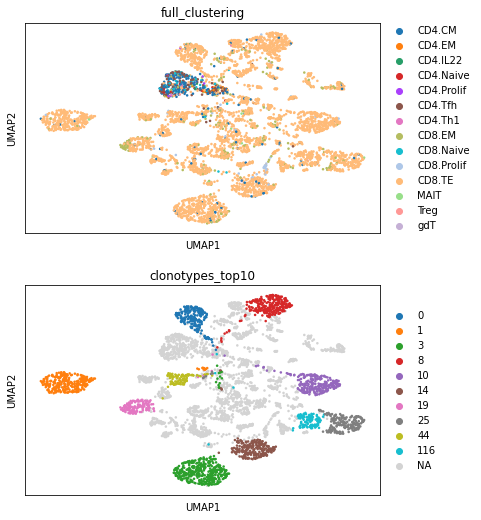

In [57]:
sc.pp.neighbors(mvtcr_embedding)
sc.tl.umap(mvtcr_embedding)
sc.pl.umap(mvtcr_embedding, color=["full_clustering", "clonotypes_top10"], ncols=1)

Here, we visualize the TCR-GEX embedding. It is clear to see, that the data separates by clonotype. However, the data forms addtional subclusters and structures within the clones, which is influenced by the GEX. Depending on your analysis, you might need to adjust the weighting between GEX and TCR and run a longer parameter search. Otherwise, different downstream task such as clustering can now be performed on this embedding using Scanpy functions.

## BCR

The three models above were developed TCRs. However, Conga and mvTCR might be applicable for B cell due to similar structures of TCR and BCR. However, both models have not been evaluated for B cells in their publication. TESSA relies on a pretrained TCR autoencoder and should therefore not be used for BCR-GEX integration. The authors recently published Benisse, which is similar to TESSA but applied on B cells. 

Similar as for TCR, multimodal BCR integration tools are still novel and have not been used in standard analysis pipelines. Therefore, we recommend causion, when applying these models.

### Benisse
Benisse embeds the heavy-chain of the BCR into a numeric embedding using a pretrained model. The model works on a clonotype level: i.e., GEX of cells with the same BCR are averaged to form representative per clone. Following, Benisse detects clones that are similar on a BCR- and GEX-level by constructing a sparse graph structure.

Since the model has a similar setup as TESSA, we will follow a the same processing steps and only comment, when details differ from above.

In [24]:
adata_benisse = adata_bc[~adata_bc.obs['IR_VDJ_1_junction_aa'].isna()]

In [63]:
df_bcr = adata_benisse.obs
df_bcr.index.name = "contigs"

df_bcr = df_bcr.rename(columns={'IR_VDJ_1_junction_aa': "cdr3"})

df_bcr = df_bcr[["cdr3"]] 

df_bcr.to_csv(f"{path_tmp}/BENISSE_bcrs.csv")
df_bcr.head(5)

,cdr3
contigs,
AAACCTGAGATGCCAG-MH9143277,CARSSIAAAGYFDYW
AAACCTGCAAGAAAGG-MH9143277,CARHEPPLVAARPTSWGAFDIW
AAACCTGGTAGCGTCC-MH9143277,CTRSLEGDIVVVPAAIHSSFDYW
AAACCTGGTCCGAAGA-MH9143277,CARGQLVGATGGDYW
AAACGGGAGGCCCTCA-MH9143277,CASPVGYW


We will filter the 1,000 most variable genes, as provided in the sample data file in the GitHub repository.

In [28]:
sc.pp.highly_variable_genes(adata_benisse, n_top_genes=1000)
adata_benisse = adata_benisse[:, adata_benisse.var["highly_variable"]].copy()

count_mat = adata_benisse.X.A
df_counts = pd.DataFrame(count_mat)

df_counts.index = adata_benisse.obs.index
df_counts.index.name = ""
df_counts.columns = adata_benisse.var.index

df_counts = df_counts.transpose()

df_counts.to_csv(f"{path_tmp}/BENISSE_gex.csv")
df_counts.head()

,AAACCTGAGATGCCAG-MH9143277,AAACCTGCAAGAAAGG-MH9143277,AAACCTGGTAGCGTCC-MH9143277,AAACCTGGTCCGAAGA-MH9143277,AAACGGGAGGCCCTCA-MH9143277,AAACGGGCAAGTAGTA-MH9143277,AAACGGGGTCAGGACA-MH9143277,AAACGGGTCCAAAGTC-MH9143277,AAACGGGTCGTAGATC-MH9143277,AAAGATGAGCCAGTTT-MH9143277,...,TTTGCGCCAGGGTACA-MH9143275,TTTGCGCCATGGGACA-MH9143275,TTTGCGCGTTCCCTTG-MH9143275,TTTGCGCTCTCCAGGG-MH9143275,TTTGGTTAGCGATATA-MH9143275,TTTGGTTAGTTAGCGG-MH9143275,TTTGTCAAGGGTCTCC-MH9143275,TTTGTCACACATAACC-MH9143275,TTTGTCACACCACCAG-MH9143275,TTTGTCAGTGCGGTAA-MH9143275
HES4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LINC01342,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MEGF6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CAMTA1-DT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RBP7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Running the model
First, we need to embed the BCR sequences via the pretrained encoder:

In [65]:
settings_embedding = {
    "input_data": f"{path_tmp}/BENISSE_bcrs.csv",
    "output_data": f"{path_res}/BENISSE_encoded_bcrs.csv",
    "cuda": "False"
}

In [66]:
cmd_bcr_embedding = "source ~/.bashrc && "
cmd_bcr_embedding += "conda activate BENISSE && "

cmd_bcr_embedding += "python Benisse/AchillesEncoder.py"
for key, value in settings_embedding.items():
    cmd_bcr_embedding += f" --{key} {value}"
cmd_bcr_embedding

'source ~/.bashrc && conda activate BENISSE && python Benisse/AchillesEncoder.py --input_data ./data/tmp/BENISSE_bcrs.csv --output_data ./data/res/BENISSE_encoded_bcrs.csv --cuda False'

In [67]:
!$cmd_bcr_embedding

Reading file:
./data/tmp/BENISSE_bcrs.csv
Loading trained model...
Embedding BCR sequences...
BCR successfully encoded. The output file is generated here:  ./data/res/BENISSE_encoded_bcrs.csv


Following, we need to create the graph representation. We will use the default values provided by the authors here.

In [109]:
cmd_benisse = ["source ~/.bashrc &&",
               "conda activate BENISSE &&",
               "export R_LIBS=$CONDA_PREFIX/lib/R/library &&",
               "Rscript Benisse/Benisse.R", 
               f"{path_tmp}/BENISSE_gex.csv",
               f"{path_tmp}/BENISSE_bcrs.csv",
               f"{path_res}/BENISSE_encoded_bcrs.csv",
               "1610 1 100 1 1 10 1e-10"]
cmd_benisse = " ".join(cmd_benisse)
cmd_benisse

'source ~/.bashrc && conda activate BENISSE && export R_LIBS=$CONDA_PREFIX/lib/R/library && Rscript Benisse/Benisse.R ./data/tmp/BENISSE_gex.csv ./data/tmp/BENISSE_bcrs.csv ./data/res/BENISSE_encoded_bcrs.csv 1610 1 100 1 1 10 1e-10'

In [110]:
!$cmd_benisse

Error in library(ggplot2) : there is no package called ‘ggplot2’
Calls: source -> withVisible -> eval -> eval -> library
Execution halted


In the next step, we will create the command for running TESSA by adding setting key and setting option.

#### Output
We now recieve three output files: hat we can further use for downstream tasks:
- **TESSA_tcr_embedding.csv**: Embedding of TCRs (without GEX information)
- **result_meta.csv**: cluster assignment by cell
- **tessa_final.RData**: Containing inferred model parameters (e.g. weightening vector b)

Here, we will use the first two files as embedding and clustering. We will store them in Scanpy format for easier handling. To avoid the clustering to be dominated by highly expanded clones, we reduce the cell-level data to a clone-level by removing duplicate TCRs.

In [14]:
tessa_embedding = pd.read_csv(f"{path_res}/TESSA_tcr_embedding.csv", index_col=0)
tessa_embedding = tessa_embedding.drop_duplicates()
tessa_obs = adata_tc[adata_tc.obs.index.isin(tessa_embedding.index)].obs
tessa_embedding = sc.AnnData(X=tessa_embedding.values, obs=tessa_obs)

Next, we will add the TESSA cluster assignment to the AnnData object. Since TESSA internally changes the barcode slightly, we will need to adjust for that. Additionally, we drop the duplicate TCRs within a cluster.

In [15]:
clustering = pd.read_csv(f"{path_res}/result_meta.csv", index_col=0)
clustering.index = clustering.index.str.replace('.', '-')
clustering = clustering[clustering.index.isin(tessa_embedding.obs.index)]
tessa_embedding.obs["TESSA_cluster"] = clustering["cluster_number"].values

print(f"Unique clones: {tessa_embedding.obs['cdr3'].nunique()}")
print(f"Unique clusters: {tessa_embedding.obs['TESSA_cluster'].nunique()}")

Unique clones: 751
Unique clusters: 132


You can see, that 751 clones were grouped to 144 clusters, which have similar TCR sequences and are likely to be functionally related. For TSNE visualisation {cite}'', we will highlight the ten largest clusters in the TCR embedding space.

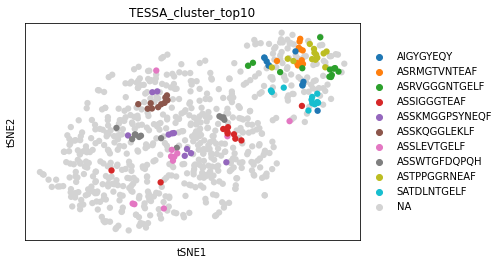

In [16]:
sc.pp.neighbors(tessa_embedding)
sc.tl.tsne(tessa_embedding)

top_10_clusters = tessa_embedding.obs["TESSA_cluster"].value_counts().head(10).index
tessa_embedding.obs["TESSA_cluster_top10"] = tessa_embedding.obs["TESSA_cluster"].apply(
    lambda x: x if x in top_10_clusters else np.nan
)

sc.pl.tsne(tessa_embedding, color="TESSA_cluster_top10")

For plotting the cluster assignemnt in the GEX space, we add the assignment to the original adata object. When plotting, we can see that TESSA clusters also share similar phenotypes at GEX level.

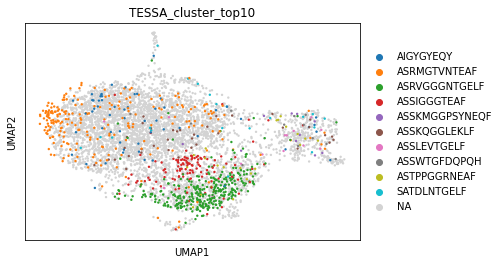

In [17]:
mapping_dict = dict(tessa_embedding.obs[['IR_VDJ_1_junction_aa', 'TESSA_cluster_top10']].values)
adata_tc.obs["TESSA_cluster_top10"] = adata_tc.obs['IR_VDJ_1_junction_aa'].map(mapping_dict)
sc.pl.umap(adata_tc, color="TESSA_cluster_top10")

# Key Takeaways

- Cell functionality (determined by IR) and cell state (observed via GEX) are interlinked. Cells with alike IR sequences share the similar phenotypes [].
- Due to the inherent structural difference between count matrixs (GEX) and amino acid sequences (IR), it is difficult to directly fuse both modalities.
- Several methods were developed to utilize paired GEX-IR data relying on different approaches such as Bayesian Models [], Graph Theory [], and Deep Learning [].
- Due to the novelty of all methods and the lack of standardarized evaluation, these are not independently benchmarked yet and are hard to compare. 
- All methods were developed for TCRs. While they can in theory easily be applied on BCR data and partially offer a BCR interface (CoGNA), this was not part of the original publication and is not evaluated yet.

# Questions
Why could it be useful to integrate IR-sequence information with gene expression?
- GEX can be used to improve IR sequence reads.
- \+ Both modalities provide different insights into the cell, while still being interdependent.
- Since both modalities capture the same information, integrating them provides an additional quality check.
- For most cells either GEX or IR is measured. Integrating thereby allows analysis of all cells.

What information provides us the IR sequence, that is not directly captured in GEX?
- A count matrix between cell and antibody-tagged epitope bindings.
- The IR sequence can be used for demultiplexing between different donors.
- \+ The cell's clonotype and thereby cell ancestory is defined by the IR sequence.
- \+ The IR sequence determines specificity and is therefor a barcode for recognizing the same epitope.

On what premise rely the approaches above?
- \+ Cells of same or alike IRs often have a similar phenotype.
- Information of IR and GEX provide orthogonal information to each other, since they are independent.
- Knowledge is transfered between large gene expression datasets into which IR data can be mapped.
- Each cell occurs clonally expanded and thereby provides multiple gene profiles.